# Import modules

In [1]:
import keras #keras 가져오기
from keras.datasets import cifar10 #cifar 10 데이터 가져오기
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils.vis_utils import model_to_dot, plot_model #loss graph를 그리기 위해 사용
from keras.optimizers import Adam #Adam optimizer 사용
from IPython.display import SVG
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Tuning parameters

In [2]:
epochs = 50 #고정
learning_rate= 0.001 #Adam에 맞는 learning rate지정

In [3]:
batch_size = 128
num_classes = 10 #클라스 개수

# Data

## Plot image

In [4]:
def plot_images(x, y_true, y_pred=None, size=(5, 5)): #이미지 확인하는 용도의 함수
    assert len(x) == len(y_true) == size[0] * size[1]
    
    fig, axes = plt.subplots(size[0], size[1])
    fig.subplots_adjust(hspace=0.5, wspace=3)

    for i, ax in enumerate(axes.flat):
        if x[i].shape[-1] == 1:
          ax.imshow(x[i].reshape(x[i].shape[0], x[i].shape[1]))
        else:
          ax.imshow(x[i])

        if y_pred is None:
            xlabel = "True: {0}".format(y_true[i].argmax())
        else:
            xlabel = "    True: {0}, Pred: {1}    ".format(y_true[i].argmax(), 
                                                   y_pred[i].argmax())

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

## Load dataset

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() #데이터 로드

170500096/170498071 [==============================] - 11s 0us/step


In [6]:
print(x_train.shape) # 데이터 크기 확인
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


## Reshaping the data

In [7]:
if len(x_train.shape) < 4:  #dimension 맞추기
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_test = x_test.reshape(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1)

In [8]:
x_train = x_train.astype('float32') #타입 변경
x_test = x_test.astype('float32')
x_train /= 255 #normalization
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## Applying One hot encoding for the data

In [9]:
y_train = keras.utils.to_categorical(y_train, num_classes) #one hot coding으로 label 변경
y_test = keras.utils.to_categorical(y_test, num_classes)

## Show data

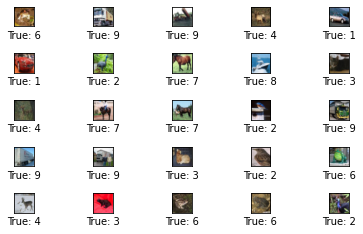

In [10]:
plot_images(x_train[:25], y_train[:25])#데이터 보여주기

# Creating the DNN model

In [11]:
model = Sequential() #DNN 구성

## Adding layers to the model

In [12]:
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:], padding='same')) #convolution layer
model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) #convolution layer
model.add(MaxPooling2D(pool_size=(2, 2))) #MaxPooling layer
model.add(Dropout(0.25)) #Dropout layer

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))#convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))#convolution layer
model.add(MaxPooling2D(pool_size=(2, 2)))#MaxPooling layer
model.add(Dropout(0.25))#Dropout layer

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))#convolution layer
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))#convolution layer
model.add(MaxPooling2D(pool_size=(2, 2)))#MaxPooling layer
model.add(Dropout(0.5))#Dropout layer

model.add(Flatten()) #dimension 하나로 변경
model.add(Dense(128, activation='relu')) #fully connected layer
model.add(Dropout(0.5))#Dropout layer
model.add(Dense(num_classes, activation='softmax')) #마지막 activation

# Model Summary

In [13]:
print(model.summary()) #모델 요약본 출력

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)         

## Visualizing the model

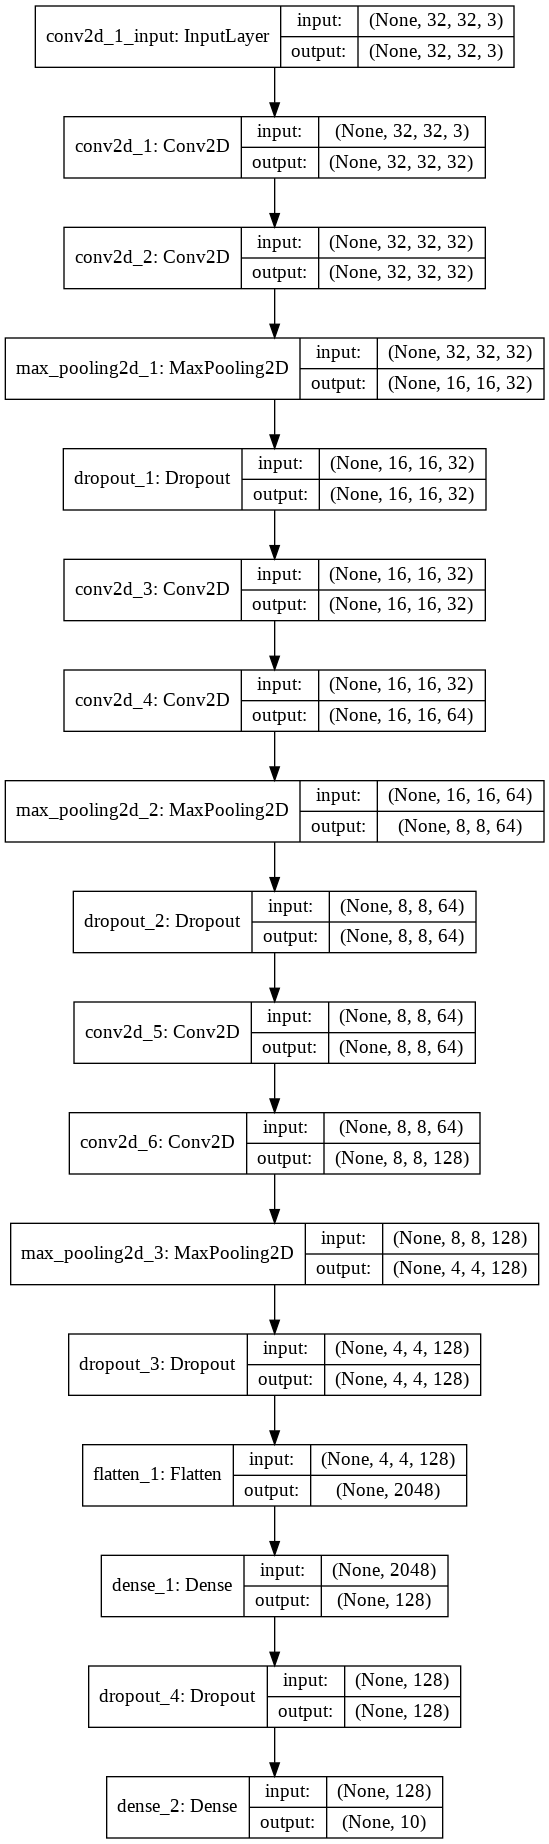

In [14]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True) #모델 도형으로 출력

## Optimizer

In [15]:
optimizer = Adam(lr=learning_rate) #optimizer를 Adam으로 설정

## Compiling the model

In [16]:
model.compile(loss=keras.losses.categorical_crossentropy, #loss function은 crossentropy
              optimizer=optimizer,  #Adam
              metrics=['accuracy']) #컴파일하기

## Training the model

In [17]:
model_details = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))#학습하기

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 20s 399us/step - loss: 1.7930 - accuracy: 0.3274 - val_loss: 1.4373 - val_accuracy: 0.4674
Epoch 2/50
50000/50000 [==============================] - 13s 264us/step - loss: 1.4086 - accuracy: 0.4857 - val_loss: 1.1812 - val_accuracy: 0.5750
Epoch 3/50
50000/50000 [==============================] - 13s 268us/step - loss: 1.2153 - accuracy: 0.5646 - val_loss: 1.0205 - val_accuracy: 0.6322
Epoch 4/50
50000/50000 [==============================] - 13s 264us/step - loss: 1.0888 - accuracy: 0.6140 - val_loss: 0.9190 - val_accuracy: 0.6757
Epoch 5/50
50000/50000 [==============================] - 13s 263us/step - loss: 1.0028 - accuracy: 0.6462 - val_loss: 0.9012 - val_accuracy: 0.6786
Epoch 6/50
50000/50000 [==============================] - 13s 263us/step - loss: 0.9408 - accuracy: 0.6691 - val_loss: 0.8364 - val_accuracy: 0.7050
Epoch 7/50
50000/50000 [==============================] 

## Evaulating the model

In [18]:
score = model.evaluate(x_test, y_test, verbose=0) #결과 얻기
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5354818522453308
Test accuracy: 0.8270999789237976


### Loss Graph - checking overfitting

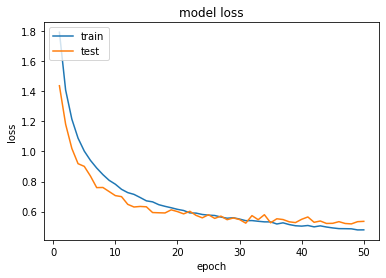

In [19]:
e = range(1, len(model_details.history['accuracy'])+1)#test set loss와 train set loss얻기
plt.plot(e, model_details.history['loss'] )
plt.plot(e, model_details.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predicting the model

In [20]:
y_pred = model.predict(x_test) #예측하기

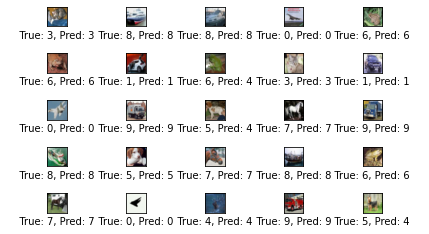

In [21]:
plot_images(x=x_test[:25], y_true=y_test[:25], y_pred=y_pred[:25]) #예측 결과 일부 출력

### Confusion Matrix

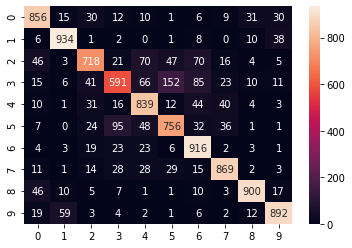

In [22]:
y_result = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))#confusion matrix 출력
sns.heatmap(pd.DataFrame(y_result, range(10), range(10)), annot=True, fmt='g')